In [209]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from IPython.display import display, clear_output
import imageio
from pathlib import Path
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/IllarionK/Projects/master_degree/.venv/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['axes', 'plot']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [210]:
base_dir = '/Users/IllarionK/Projects/master_degree'
frames_dir = os.path.join(base_dir, 'frames')
os.makedirs(frames_dir, exist_ok=True)
video_dir = os.path.join(base_dir, 'videos')
os.makedirs(video_dir, exist_ok=True)

# Settings and parameters

In [125]:
### Settings and parameters
NORM_LENGTH_X = 4
NORM_LENGTH_Y = 1
PIXEL_MULTIPLIER = 100
LENGTH_X  = NORM_LENGTH_X * PIXEL_MULTIPLIER    # resolution x direction  # default 400
LENGTH_Y  = NORM_LENGTH_Y * PIXEL_MULTIPLIER    # resolution y direction
RHO_0     = 1      # average density
TAU       = 0.6    # collision timescale (relaxation term)
# TAU = 1
# tau = 1.9739
# tau = 0.9
N_STEPS   = 4000   # number of timesteps
# 1.7 for water
U_MAX     = 0.1    # maximum velocity of Poiseuille inflow
INLET_IDX = 0
OUTLET_IDX = LENGTH_X - 1
PIPE_LENGTH = LENGTH_Y - 2  # L
INLET_SL = np.s_[:, 0]
OUTLET_SL = np.s_[:, LENGTH_X - 1]

In [102]:
### Cylinder parameters
# X.shape: (100, 400) Y shape: (100, 400)
X, Y = np.meshgrid(range(LENGTH_X), range(LENGTH_Y))
# INFO: shape the same as all space, but only partially filled with cylinder
# cylinder shape: (100, 400)
NORM_CYLINDER_RADIUS = 0.125
CYLINDER_RADIUS = int(NORM_CYLINDER_RADIUS * LENGTH_Y)
print("CYLINDER_RADIUS:", CYLINDER_RADIUS)
# True within cylinder boundaries
Y_SHIFT = 0
CYLINDER_MASK = (X - LENGTH_X / 4) ** 2 + (Y - LENGTH_Y / 2 + Y_SHIFT) ** 2 < (CYLINDER_RADIUS) ** 2
# pylab.imshow(CYLINDER_MASK, cmap='gray')

CYLINDER_RADIUS: 12


In [87]:
### new constants
# laminar when Re < 2300
# transient when 2300 < Re < 4000
# turbulent when 4000 < Re
RE = 2
NU = U_MAX * 2 * CYLINDER_RADIUS / RE
# TAU  = 1 / (3 * NU + 1/2);
print("NU:", NU)
print("TAU:", TAU)
# TAU = 0.6

NU: 1.2000000000000002
TAU: 1


## Vector params

In [4]:
### Vectors params
# General params
LEFT_COL_NAMES = ["NW", "W", "SW"]
CENT_COL_NAMES = ["N", "C", "S"]
RIGHT_COL_NAMES = ["NE", "E", "SE"]
N_VECTORS = 9
VECTOR_INDEXES = np.arange(N_VECTORS)

### New style

In [89]:
# New style lattices definitions
VECTORS_VELOCITIES_X_NEW = np.array([
    [-1, 0, 1,],
    [-1, 0, 1,],
    [-1, 0, 1,],
]).reshape(-1)
VECTORS_VELOCITIES_Y_NEW = np.array([
     [1,  1,  1,],
     [0,  0,  0,],
    [-1, -1, -1,],
]).reshape(-1)
VECTORS_WEIGHTS_NEW = np.array([
    [1/36, 1/9, 1/36,],
    [1/9,  4/9, 1/9,],
    [1/36, 1/9, 1/36,],
]).reshape(-1)
LAT_LEFT_COL_SL_NEW = np.s_[:, [0, 3, 6]]
LAT_CENT_COL_SL_NEW = np.s_[:, [1, 4, 7]]
LAT_RIGHT_COL_SL_NEW= np.s_[:, [2, 5, 8]]
# 'NW' 'N' 'NE' 'W' 'C' 'E' 'SW' 'S' 'SE'
#   0   1    2   3   4   5    6   7    8
VECTORS_DIRECTIONS_NEW = np.array([
    ['NW', 'N', 'NE',],
    ['W',  'C',  'E',],
    ['SW', 'S', 'SE',],
]).reshape(-1)
assert np.all(VECTORS_DIRECTIONS_NEW[LAT_LEFT_COL_SL_NEW[1]] == LEFT_COL_NAMES)
assert np.all(VECTORS_DIRECTIONS_NEW[LAT_CENT_COL_SL_NEW[1]] == CENT_COL_NAMES)
assert np.all(VECTORS_DIRECTIONS_NEW[LAT_RIGHT_COL_SL_NEW[1]] == RIGHT_COL_NAMES)
CYL_BOUNCE_BACK_DIRECTIONS_NEW = [8, 7, 6, 5, 4, 3, 2, 1, 0]

### Choose variables style

In [90]:
style = "NEW"
VECTORS_VELOCITIES_X = eval(f"VECTORS_VELOCITIES_X_{style}")
VECTORS_VELOCITIES_Y = eval(f"VECTORS_VELOCITIES_Y_{style}")
VECTORS_WEIGHTS = eval(f"VECTORS_WEIGHTS_{style}")
LAT_LEFT_COL_SL = eval(f"LAT_LEFT_COL_SL_{style}")
LAT_CENT_COL_SL = eval(f"LAT_CENT_COL_SL_{style}")
LAT_RIGHT_COL_SL = eval(f"LAT_RIGHT_COL_SL_{style}")
VECTORS_DIRECTIONS = eval(f"VECTORS_DIRECTIONS_{style}")
CYL_BOUNCE_BACK_DIRECTIONS = eval(f"CYL_BOUNCE_BACK_DIRECTIONS_{style}")

# Predefined funstions
## Tensorflow helper methods

## Initial contisions func

In [185]:
### Initial conditions
def init_random_cos():
    # F.shape: (100, 400, 9)
    F = np.ones((LENGTH_Y, LENGTH_X, N_VECTORS)) #* RHO_0 / N_VECTORS
    np.random.seed(42)
    F += 0.01 * np.random.randn(LENGTH_Y, LENGTH_X, N_VECTORS)
    X, _ = np.meshgrid(range(LENGTH_X), range(LENGTH_Y))
    # F[0, 0] - 0.99 .. 3.45
    F[:, :, 5] += 2 * (1 + 0.2 * np.cos(2 * np.pi * X / LENGTH_X * 4))  # 1.6..2.4
    rho = np.sum(F, 2)
    for i in VECTOR_INDEXES:
        F[:, :, i] *= RHO_0 / rho
    # F[0, 0] - 8 .. 29
    return F

def poiseuille_profile_old(y_phys):
    # looks like a picture from here
    # https://www.simscale.com/docs/validation-cases/hagen-poiseuille-flow/
    return 4 * U_MAX / (PIPE_LENGTH ** 2) * (y_phys * PIPE_LENGTH - y_phys * y_phys)

def poiseuille_profile_new(y_phys):
    L = 2 * CYLINDER_RADIUS  # характерный размер
    nu = U_MAX * L / RE
    G = 1 / 100000
    ux = G / (2 * nu) * y_phys * (LENGTH_Y - y_phys)
    return ux


def init_poiseuille():
    rho = 1
    y, x = np.meshgrid(np.arange(LENGTH_Y), np.arange(LENGTH_X))
    F = np.empty((LENGTH_X, LENGTH_Y, N_VECTORS))
#     y_phys = y - 0.5;
    ux = poiseuille_profile_new(y)
    uy = np.zeros((LENGTH_X, LENGTH_Y))
    
    for idx in range(9):
        # 300, 100
        cu = 3 * (VECTORS_VELOCITIES_X[idx] * ux + VECTORS_VELOCITIES_Y[idx] * uy);
        # 300, 100
        res = rho * VECTORS_WEIGHTS[idx] * (1 + cu + 1/2 * cu ** 2 - 3/2*(ux**2 + uy **2));
        F[:, :, idx] = res
    F = np.rot90(F)
    return F

## Debug poiseuille_profile

nu: 0.012000000000000002
tau: 0.504


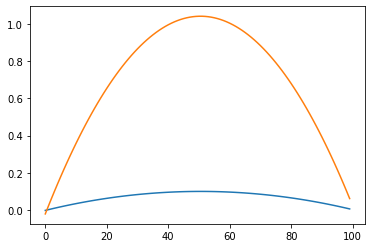

In [177]:

RE = [20, 40, 60, 100, 200][-1]
L = 2 * CYLINDER_RADIUS  # характерный размер
nu = U_MAX * L / RE
print("nu:", nu)

y, x = np.meshgrid(np.arange(LENGTH_Y), np.arange(LENGTH_X))
# y_phys[0, :] = -0.5 .. 95.5
# 400..100
y_phys = y - 0.5;

ux = 4 * U_MAX / (LENGTH_Y ** 2) * (y_phys * LENGTH_Y - y_phys * y_phys)
res = ux
# res = (y_phys * PIPE_LENGTH - y_phys * y_phys)
pylab.plot(res[0, :])

column = np.arange(LENGTH_Y)
G = LENGTH_Y
G = 1 / 100000
# from wiki
ux = G / (2 * nu) * y_phys * (LENGTH_Y - y_phys)
pylab.plot(ux[0, :])

tau = nu / 3 + 0.5
print("tau:", tau)


In [113]:
y.shape

(400, 100)

## Equality functions
### Old style

In [92]:
def calc_ba_eq(F):
    F_eq = np.zeros(F.shape)
    for i, cx, cy, w in zip(VECTOR_INDEXES, VECTORS_VELOCITIES_X, VECTORS_VELOCITIES_Y, VECTORS_WEIGHTS):
        # (100, 400)
        F_eq[:,:,i] = rho * w * ( 1 + 3*(cx*ux+cy*uy)  + 9*(cx*ux+cy*uy)**2/2 - 3*(ux**2+uy**2)/2 )
    print_v("F_eq_ba:\n", F_eq[0][0])
    return F_eq

### np equality

In [13]:
def calc_np_eq(data_flat):
    F = data_flat
    F_eq_l = np.zeros(F.shape)
    for x_idx in range(F.shape[0]):
        for y_idx in range(F.shape[1]):
            lattice = F[x_idx, y_idx, :]
            rho_l = np.sum(lattice)
            ux_l = np.sum(lattice * VECTORS_VELOCITIES_X) / rho_l
            uy_l = np.sum(lattice * VECTORS_VELOCITIES_Y) / rho_l
            u_sum = VECTORS_VELOCITIES_X * ux_l + VECTORS_VELOCITIES_Y * uy_l
            F_eq_lattice = rho_l * VECTORS_WEIGHTS * (
                1 + 3 * (u_sum) + 9 * (u_sum) ** 2 / 2 - 3 * (ux_l ** 2 + uy_l ** 2) / 2
            )
            F_eq_l[x_idx, y_idx, :] = F_eq_lattice
    print_v("F_eq_np:\n", F_eq_l[0][0])
    return F_eq_l

### tf equality

In [14]:
### Tensorflow helper methods
def build_graph():
    dtype = tf.float32
    velocities_x_tf = tf.constant(VECTORS_VELOCITIES_X, dtype=dtype)
    velocities_y_tf = tf.constant(VECTORS_VELOCITIES_Y, dtype=dtype)
    weights_tf = tf.constant(VECTORS_WEIGHTS, dtype=dtype)
    
    def ones_init(shape, dtype=None, partition_info=None):
        kernel = np.zeros(shape)
        kernel[0, 0, :, 0] = 1.0
        return tf.cast(kernel, dtype)

    sum_conv = tf.keras.layers.Conv2D(1, (1, 1), kernel_initializer=ones_init)

    def vel_x_init_many_to_one(shape, dtype=None, partition_info=None):
        kernel = np.zeros(shape)
        kernel[0, 0, :, 0] = VECTORS_VELOCITIES_X
        return tf.cast(kernel, dtype)

    vel_x_conv = tf.keras.layers.Conv2D(1, (1, 1), kernel_initializer=vel_x_init_many_to_one)

    def vel_y_init_many_to_one(shape, dtype=None, partition_info=None):
        kernel = np.zeros(shape)
        kernel[0, 0, :, 0] = VECTORS_VELOCITIES_Y
        return tf.cast(kernel, dtype)

    vel_y_conv = tf.keras.layers.Conv2D(1, (1, 1), kernel_initializer=vel_y_init_many_to_one)
    return velocities_x_tf, velocities_y_tf, weights_tf, sum_conv, vel_x_conv, vel_y_conv

In [15]:
def calc_tf_eq_core(data_flat, tf_params):
    velocities_x_tf, velocities_y_tf, weights_tf, sum_conv, vel_x_conv, vel_y_conv = tf_params
#     batch = data_flat.reshape(1, *data_flat.shape)
    batch = data_flat
#     rho = sum_conv(batch)
    rho = tf.cast(tf.expand_dims(tf.math.reduce_sum(batch, axis=3), axis=-1), tf.float32)
    ux_lattices = vel_x_conv(batch) / rho
    uy_lattices = vel_y_conv(batch) / rho
    ux_elements = tf.math.multiply(ux_lattices, velocities_x_tf)
    uy_elements = tf.math.multiply(uy_lattices, velocities_y_tf)
    before_weights = (
        1 + 3 * (ux_elements + uy_elements) +
        9 * (ux_elements + uy_elements) ** 2 / 2 - 
        3 * (ux_lattices ** 2 + uy_lattices ** 2) / 2
    )
    after_weights = tf.math.multiply(before_weights, weights_tf)
    F_eq = tf.math.multiply(rho, after_weights)
#     F_eq = F_eq.numpy().squeeze()
#     print_v("F_eq_tf:\n", F_eq[0][0])
    return F_eq

calc_tf_eq_func = tf.function(calc_tf_eq_core)
TF_PARAMS = build_graph()

def calc_tf_eq(data_flat):
    batch = data_flat.reshape(1, *data_flat.shape)
    return calc_tf_eq_func(batch, TF_PARAMS).numpy().squeeze()

2021-11-15 21:50:02.045837: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Optimized tf

In [16]:
from tensorflow.keras import Input, Model

batch = Input(shape=(LENGTH_Y, LENGTH_Y, N_VECTORS))
velocities_x_tf, velocities_y_tf, weights_tf, sum_conv, vel_x_conv, vel_y_conv = build_graph()
# rho = sum_conv(batch)
rho = tf.expand_dims(tf.math.reduce_sum(batch, axis=3), axis=-1)
ux_lattices = vel_x_conv(batch) / rho
uy_lattices = vel_y_conv(batch) / rho
ux_elements = tf.math.multiply(ux_lattices, velocities_x_tf)
uy_elements = tf.math.multiply(uy_lattices, velocities_y_tf)
before_weights = (
    1 + 3 * (ux_elements + uy_elements) +
    9 * (ux_elements + uy_elements) ** 2 / 2 - 
    3 * (ux_lattices ** 2 + uy_lattices ** 2) / 2
)
after_weights = tf.math.multiply(before_weights, weights_tf)
F_eq = tf.math.multiply(rho, after_weights)
model = Model(inputs=batch, outputs=F_eq)
# graph_model = tf.function(model)
tf.saved_model.save(model, '/tmp/model')
loaded = tf.saved_model.load('/tmp/model')
infer = loaded.signatures["serving_default"]

def predict(data):
    data_batch = data.reshape(1, *data.shape)
    tf_res = infer(tf.constant(data_batch, dtype=tf.float32))
    np_res = tf_res[model.output_names[0]].numpy().squeeze()
    return np_res

2021-11-15 21:50:02.555859: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/model/assets


In [ ]:
writer = imageio.get_writer('test.mp4', fps=20)

for im in fileList:
    writer.append_data(imageio.imread(im))
writer.close()

In [70]:
def vorticity_to_image(vorticity):
    vmin = np.min(vorticity)
    vmax = np.max(vorticity)
    value = (u - vmin) / (vmax - vmin)
    value = np.squeeze(value)
    indices = np.round(value * 255).astype(np.int32)
    return indices
    colors = tf.constant(velocity_color_map.colors, dtype=tf.float32)
    value = tf.gather(colors, indices)
    value_casted = tf.cast(tf.round(value * 255), tf.int32)
    # add alpha channel
    alpha_channel = tf.cast(tf.ones((100, 400, 1)) * 255, tf.int32)
    value_with_alpha = tf.concat([value_casted, alpha_channel], 2)
    return tf.cast(value_with_alpha, tf.uint8)

# Simulation loop

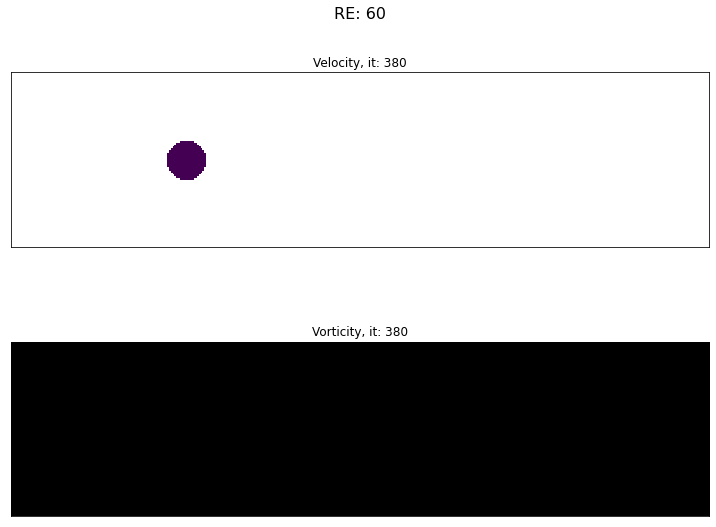

KeyboardInterrupt: 

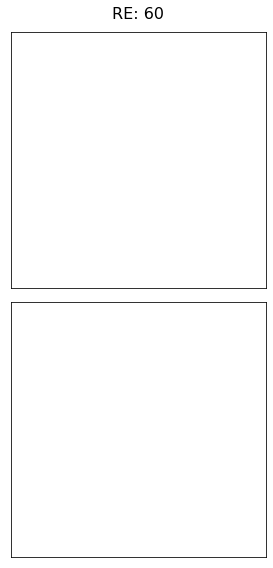

In [218]:
### Simulation(main loop)
cmap = plt.cm.bwr.copy()
cmap.set_bad('black')

RE = [20, 40, 60, 100, 200][2]
res_frame_dir = os.path.join(frames_dir, str(RE))
os.makedirs(res_frame_dir, exist_ok=True)
plot = True
# PRINT = not plot
PRINT = False
macroscopic = True
if plot:
    fig, axes = plt.subplots(2, figsize=(10, 8))
    fig.suptitle(f'Re: {RE}', fontsize=16)
    for ax in axes:
        ax.invert_yaxis()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_aspect('equal')
    fig.tight_layout()

# F = init_random_cos()
F = init_poiseuille()
# F = init_poiseuille() + init_random_cos() / 10

def print_v(*data):
    if not plot and PRINT:
        print(*data)

MODE = 'tf'
# old - 00:00:47
# np -  01:30:45
# tf -  00:01:40
# tf -  00:00:56  # function optimized
# tfopt 00:00:56  # Optimized via saving
for it in tqdm(range(N_STEPS), disable=plot):
# for it in range(10):

    # Set reflective boundaries
    bndryF = F[CYLINDER_MASK,:]   # shape: (3405, 9)
    # Action: to all cylinder coordinates assign such f_i values
    # can be replaced with mirroring matrix over center
    # bndryF.reshape(-1, 3, 3)[:, ::-1][::-1, :].reshape(-1, 9);
    bndryF = bndryF[:, CYL_BOUNCE_BACK_DIRECTIONS]

    ### 1. Compute moments (for each latice)
    rho = np.sum(F, 2)  # shape: (100, 400)
    ux  = np.sum(F * VECTORS_VELOCITIES_X, 2) / rho   # shape: (100, 400)
    uy  = np.sum(F * VECTORS_VELOCITIES_Y, 2) / rho   # shape: (100, 400)
    
    if macroscopic:
        ### 1.1 Compute macroscopic (dirichlet) boundary conditions
        ##  Inlet: Poiseuille profile
        y_phys = np.arange(LENGTH_Y) - 0.5
        ux[INLET_SL] = poiseuille_profile(y_phys)
        uy[INLET_SL] = 0
        rho[INLET_SL] = 1 / (1 - ux[INLET_SL] * (
            F[INLET_SL][LAT_CENT_COL_SL].sum(axis=1) +
            2 * F[INLET_SL][LAT_LEFT_COL_SL].sum(axis=1))
        )
        ##  Outlet: Constant pressure
        print_v('-')
        print_v("rho outlet before", rho[OUTLET_SL].mean())
        rho[OUTLET_SL] = 1
        print_v("rho outlet after", rho[OUTLET_SL].mean())
        print_v("rho total", rho.mean())
        print_v("F[OUTLET_SL][LAT_CENT_COL_SL].sum(axis=1)", np.mean(F[OUTLET_SL][LAT_CENT_COL_SL].sum(axis=1)))
        print_v("2 * F[OUTLET_SL][LAT_RIGHT_COL_SL].sum(axis=1)", np.mean(2 * F[OUTLET_SL][LAT_RIGHT_COL_SL].sum(axis=1)))

        print_v("ux before", ux[OUTLET_SL].mean())
        ux[OUTLET_SL] = -1 + 1 / rho[OUTLET_SL] * (
            F[OUTLET_SL][LAT_CENT_COL_SL].sum(axis=1) +
            2 * F[OUTLET_SL][LAT_RIGHT_COL_SL].sum(axis=1)
        )
        print_v("ux after", ux[OUTLET_SL].mean())
        uy[OUTLET_SL] = 0

    ### 2. Compute equilibrium
    if MODE == 'old':
        F_eq = calc_ba_eq(F)
    elif MODE == 'np':
        F_eq = calc_np_eq(F)
    elif MODE == 'tf':
        F_eq = calc_tf_eq(F)
    elif MODE == 'tf_opt':
        F_eq = predict(F)

    ### 3. Collide locally
    F = F - (F - F_eq) / TAU

    # Apply boundary 
    F[CYLINDER_MASK, :] = bndryF
    
    ### 4. Propagate to the neighbours
    for i, cx, cy in zip(VECTOR_INDEXES, VECTORS_VELOCITIES_X, VECTORS_VELOCITIES_Y):
        F[:, :, i] = np.roll(F[:, :, i], (cx, cy), axis=(1, 0))
        

    if (it % 10 == 0 or it == N_STEPS - 1) and plot:
        fig, axes = plt.subplots(2, figsize=(10, 8))
        fig.suptitle(f'RE: {RE}', fontsize=16)
        for ax in axes:
            ax.invert_yaxis()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_aspect('equal')
        fig.tight_layout()
        ux[CYLINDER_MASK] = 0
        uy[CYLINDER_MASK] = 0
        # Note: Calculate vorticity as a difference 
        # Note: np.roll(ux, -1, axis=0) - shift all X velocity by one ROW down
        # vorticity.shape: (100, 400)
        vorticity = (
            (np.roll(ux, -1, axis=0) - np.roll(ux, 1, axis=0)) - 
            (np.roll(uy, -1, axis=1) - np.roll(uy, 1, axis=1))
        )
#         vorticity = vorticity_to_image(vorticity)
        vorticity[CYLINDER_MASK] = np.nan
#         vorticity[CYLINDER_MASK] = 0
        
        # display velocity
        rho = np.sum(F, 2)
        ux  = np.sum(F * VECTORS_VELOCITIES_X, 2) / rho
        uy  = np.sum(F * VECTORS_VELOCITIES_Y, 2) / rho
        u = np.sqrt(ux ** 2 + uy ** 2)
        u[CYLINDER_MASK] = 0
        axes[0].cla()
        axes[0].set_title(f"Velocity, it: {it}")
        axes[0].imshow(u)
        
        # Works but blink all the time
        axes[1].cla()
        axes[1].set_title(f"Vorticity, it: {it}")
        axes[1].imshow(vorticity, cmap=cmap)
        axes[1].get_images()[0].set_clim(-.1, .1)
        display(fig)
        pylab.savefig(os.path.join(res_frame_dir, str(it)))
        clear_output(wait=True)
        plt.pause(0.001)

#         image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
#         image_reshaped = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [ ]:
for re_dir in os.listdir(frames_dir):
    video_path = os.path.join(video_dir, re_dir + '.mp4')
    re_frames_dir = os.path.join(frames_dir, re_dir)
    if not os.path.isdir(re_frames_dir):
        continue
    with imageio.get_writer(video_path, mode='I') as writer:
        for image_path in sorted(os.listdir(re_frames_dir), key=lambda x: int(x.split('.')[0])):
            image = imageio.imread(os.path.join(re_frames_dir, image_path))
            writer.append_data(image)